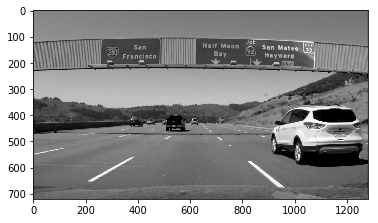

(720, 1280)


In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image = mpimg.imread('signs_vehicles_xygrad.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()
print(gray_image.shape)

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # calculate gradient in x or y direction
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1,0,  ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0,1,  ksize=sobel_kernel)
    # calculate and convert to unit8
    abs_sobel = np.absolute(sobel)
    uni = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros(img.shape)
    sobel_binary[(uni>thresh[0]) & (uni<thresh[1])] = 1
    
    return sobel_binary

In [3]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1,0,  ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0,1,  ksize=sobel_kernel)
    grad_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    uni = np.uint8(255*grad_sobel/np.max(grad_sobel))
    sobel_binary = np.zeros(img.shape)
    sobel_binary[(uni>=mag_thresh[0]) & (uni<=mag_thresh[1])] = 1
    
    return sobel_binary

In [4]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1,0,  ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0,1,  ksize=sobel_kernel)
    grad = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    sobel_binary = np.zeros(img.shape)
    sobel_binary[(grad>=thresh[0]) & (grad<=thresh[1])] = 1
    
    return sobel_binary

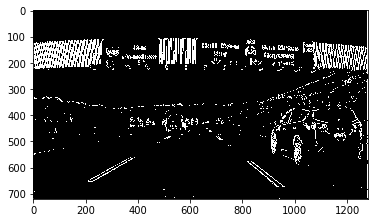

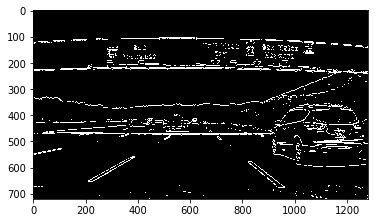

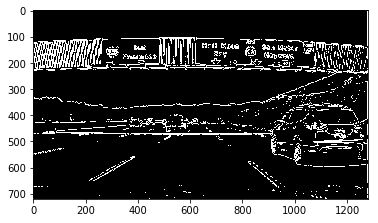

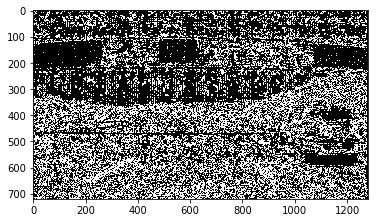

In [84]:
ksize = 3 
gradx = abs_sobel_thresh(gray_image, orient='x', sobel_kernel=ksize, thresh=(20, 150))
plt.imshow(gradx, cmap='gray')
plt.show()

grady = abs_sobel_thresh(gray_image, orient='y', sobel_kernel=ksize, thresh=(30, 150))
plt.imshow(grady, cmap='gray')
plt.show()

mag_binary = mag_thresh(gray_image, sobel_kernel=ksize, mag_thresh=(30, 100))
plt.imshow(mag_binary, cmap='gray')
plt.show()

dir_binary = dir_threshold(gray_image, sobel_kernel=ksize, thresh=(0.6, 1.4))
plt.imshow(dir_binary, cmap='gray')
plt.show()

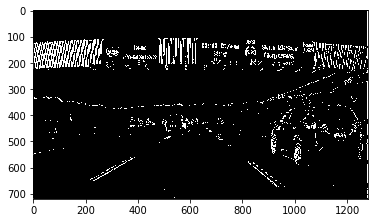

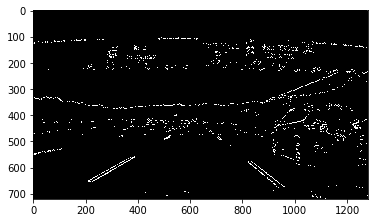

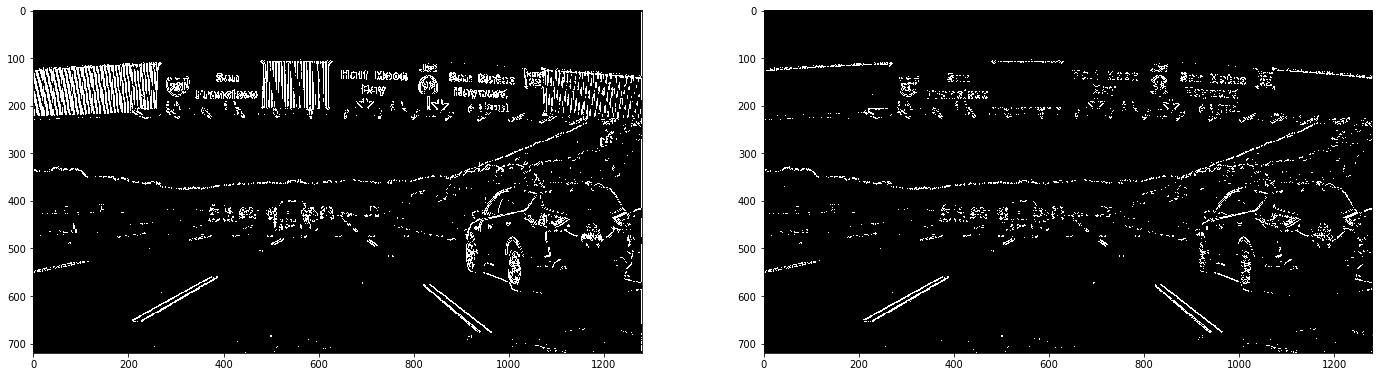

In [85]:
combined1 = np.zeros_like(dir_binary)

combined1[ ((gradx==1)&(mag_binary == 1))] = 1

plt.imshow(combined1, cmap='gray')
plt.show()

combined2 = np.zeros_like(dir_binary)
combined2[ (grady==1) & (dir_binary == 1)] = 1
plt.imshow(combined2, cmap='gray')
plt.show()

combined3 = np.zeros_like(dir_binary)
combined3[ ((dir_binary == 1) & (grady==1))|((gradx==1)&(mag_binary == 1))] = 1
combined4 = np.zeros_like(dir_binary)
combined4[ ((gradx==1) & (grady==1))|((dir_binary == 1)&(mag_binary == 1))] = 1

#combined3[(combined1==1)|(combined2==1)] =1
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.imshow(combined3, cmap='gray')
ax2.imshow(combined4, cmap='gray')

plt.show()

### Locate the Lane Lines and Fit a Polynomial

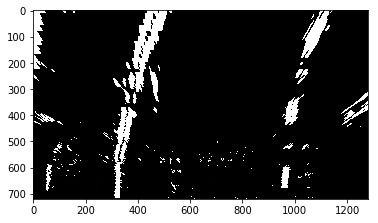

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
img = cv2.imread('warped-example.jpg',0)
plt.imshow(img, cmap='gray')
plt.show()

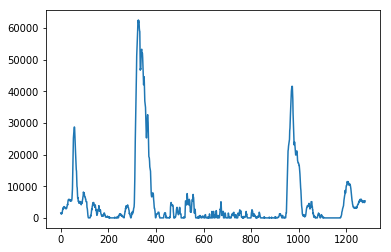

In [2]:
histgram = np.sum(img[img.shape[0]//2:, :], axis=0)
plt.plot(histgram)
plt.show()

In [3]:
hist = np.sum(img[img.shape[0]//2:,:], axis=0)
out_img = np.dstack((img, img, img))*255

midpoint = np.int(hist.shape[0]/2)
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint:]) + midpoint
print(leftx_base, rightx_base)
print(hist)


327 971
[1554 1306 1292 ..., 5091 5097 5347]


In [4]:
nwindows = 9
window_height = np.int(img.shape[0]/nwindows)

nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base

margin = 100

minpix = 50

left_lane_inds = []
right_lane_inds = []
print(nonzeroy)
print(nonzerox)

[  0   0   0 ..., 719 719 719]
[   0    1    2 ..., 1051 1067 1069]


In [5]:
for window in range(nwindows):
    win_y_low = img.shape[0] - (window+1)*window_height
    win_y_high = img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    print(good_left_inds)
    print(good_right_inds)
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

[82135 82136 82137 ..., 89382 89383 89384]
[82165 82166 82167 ..., 89483 89484 89485]
[71398 71399 71400 ..., 82048 82049 82050]
[74209 74210 74211 ..., 82107 82108 82109]
[63608 63609 63610 ..., 71368 71369 71370]
[63674 63675 63676 ..., 69105 69106 69107]
[53979 53980 53981 ..., 63589 63590 63591]
[54048 54049 54050 ..., 63595 63596 63597]
[43839 43840 43841 ..., 53821 53822 53823]
[43887 43888 43889 ..., 53884 53885 53886]
[35496 35497 35498 ..., 43812 43813 43814]
[35567 35568 35569 ..., 41641 41745 41746]
[27226 27227 27228 ..., 35447 35448 35449]
[27291 27292 27293 ..., 35490 35491 35492]
[14706 14707 14708 ..., 27159 27160 27161]
[14770 14771 14772 ..., 27194 27195 27196]
[   77    78    79 ..., 14619 14620 14621]
[  170   171   172 ..., 14685 14686 14687]


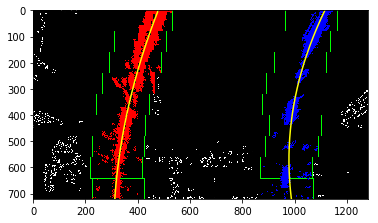

In [6]:
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Lane detection for rest frames

In [ ]:
nonzero = img.nonzero()
nonzerox = nonzero[1]
nonzeroy = nonzero[0]
margin = 100
left_lane_ind = ((nonzerox>(left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]-margin)) & (nonzerox>(left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]+margin)))
right_lane_ind = ((nonzerox>(right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]-margin)) & (nonzerox>(right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]+margin)))

In [ ]:
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
fit_leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
fit_rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#### Plot

In [ ]:
# create an image to draw on and an image to show the selection window
out_img = np.dstack((img, img, img)) *255
window_img = np.zeros_like(out_img)

# color in the left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0 0]
out_img[nonzeroy[right_lane_inds], nonzeroy[right_lane_inds]] = [0, 0, 255]

# create window to illustrate search area
left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin,ploty]))])
left_line_wondow2 = np.array([])